An Analysis and _________ of AirBnb Data
by Arushi Patel, Jerry Sun and Nathan Laieke

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as smodel
import sklearn
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as stmf
import os
import re
import unicodedata
#import nltk
# Imports from sklearn for ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

#We are removing this right?#
# NY DATA
nyDataFrame = pd.read_csv('AB_NYC_2019.csv')
nyDataFrame['coordinates'] = nyDataFrame['latitude'].astype(str) + ', ' + nyDataFrame['longitude'].astype(str)
del nyDataFrame['latitude']
del nyDataFrame['longitude']

# Replace neighborhood group with city
nyDataFrame.columns = ['city' if x=='neighbourhood_group' else x for x in nyDataFrame.columns]
# Move city column towards beginning
nyDataFrame = nyDataFrame[["id","host_id","name","host_name","city","neighbourhood","room_type","price","minimum_nights","number_of_reviews","last_review",
                             "reviews_per_month","calculated_host_listings_count","availability_365","coordinates"]]
# Group by city and neighborhood and sort by the most number of reviews
nyDataFrame.sort_values(["city","neighbourhood","number_of_reviews"],ascending = [True,True,False])


In [2]:

# USA DATA
usaDataFrame = pd.read_csv('AB_US_2020.csv')
del usaDataFrame['neighbourhood_group']
usaDataFrame['coordinates'] = usaDataFrame['latitude'].astype(str) + ', ' + usaDataFrame['longitude'].astype(str)
del usaDataFrame['latitude']
del usaDataFrame['longitude']

# Make city column one of the first few columns
usaDataFrame = usaDataFrame[["id","host_id","name","host_name","city","neighbourhood","room_type","price","minimum_nights","number_of_reviews",
                             "last_review","reviews_per_month","calculated_host_listings_count","availability_365","coordinates"]]
# Group by city and neighborhood and sort by the most number of reviews
usaDataFrame.sort_values(["city","neighbourhood","number_of_reviews"],ascending = [True,True,False])

#Dealing with nulls in USA data
usaDataFrame.isnull().sum()
usaData2 = usaDataFrame
#check for the num of unique data points in each feature
usaData2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('int').apply(pd.Series.nunique, axis = 0)
usaData2.select_dtypes('float').apply(pd.Series.nunique, axis = 0)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


id    host_id  \
276     11701027   37737144   
738     21947972  141218676   
352     13700790   37737144   
820     23498234  169331389   
157      5850649   30377862   
...          ...        ...   
222492  23731595   59460146   
222738  25294169  191067732   
224443  38189405  104560694   
225104  42061938  331138523   
225204  42448143   23714240   

                                                     name host_name  \
276         Spacious 700 sq. ft. Suite in South Asheville    Kwadwo   
738                Houz Zen: A Pet Friendly Private Suite     Corey   
352                          Cozy Room in South Asheville    Kwadwo   
820                                       Bran Rick Cabin      Eric   
157     Explore the Woods from a Quiet Apartment near ...    Daniel   
...                                                   ...       ...   
222492                  DC Room - Queen bed and full bath      Ryan   
222738                                 Cozy guest bedroom    Tierra   
224443  PEACH PARADISE @ Woodridge  Abbey Bed & Breakfast  Michelle   
225104                  Cozy, Clean , Convenient DC home!   Chikere   
225204       Monroe St-Modern & Chic-BR with Free Parking      Nana   

                   city                     neighbourhood        room_type  \
276           Asheville                             28704  Entire home/apt   
738           Asheville                             28704  Entire home/apt   
352           Asheville                             28704     Private room   
820           Asheville                             28704     Private room   
157           Asheville                             28704  Entire home/apt   
...                 ...                               ...              ...   
222492  Washington D.C.  Woodridge, Fort Lincoln, Gateway     Private room   
222738  Washington D.C.  Woodridge, Fort Lincoln, Gateway     Private room   
224443  Washington D.C.  Woodridge, Fort Lincoln, Gateway     Private room   
225104  Washington D.C.  Woodridge, Fort Lincoln, Gateway     Private room   
225204  Washington D.C.  Woodridge, Fort Lincoln, Gateway  Entire home/apt   

        price  minimum_nights  number_of_reviews last_review  \
276        66               1                355    10/09/20   
738        90               2                320    22/09/20   
352        44               1                307    20/09/20   
820        52               1                281    20/09/20   
157       102               7                263    03/04/20   
...       ...             ...                ...         ...   
222492    150               1                  0         NaN   
222738     65               1                  0         NaN   
224443     30              14                  0         NaN   
225104     55               2                  0         NaN   
225204    149              14                  0         NaN   

        reviews_per_month  calculated_host_listings_count  availability_365  \
276                  6.42                               4                 0   
738                  9.47                               2                 0   
352                  5.95                               4               343   
820                  9.09                               1               341   
157                  4.95                               1                 0   
...                   ...                             ...               ...   
222492                NaN                               1                90   
222738                NaN                               1               364   
224443                NaN                               2                 0   
225104                NaN                               1                 0   
225204                NaN                               4                 0   

                          coordinates  
276               35.47528, -82.50271  
738               35.45308, -82.50511  
352          

STEP 1: Reading and Cleaning the Data
As seen above, the USA data is broken into various numerical and categorial features. Some interesting features include neighborhood, neighborhood group, and ... what other stuff did you look at Nathan? 
Neighborhood: contained postal codes.
Neighborhood Group: Contains missing data.
We cleaned this data of (NATHAN FILL IN HOW YOU CLEANED THE DATA)

STEP 2: Observing Numerical Features
Now that the data has been cleaned, we can start to look for outliers in the data. In order to do this we ploted the density distribution for each numerical feature.  

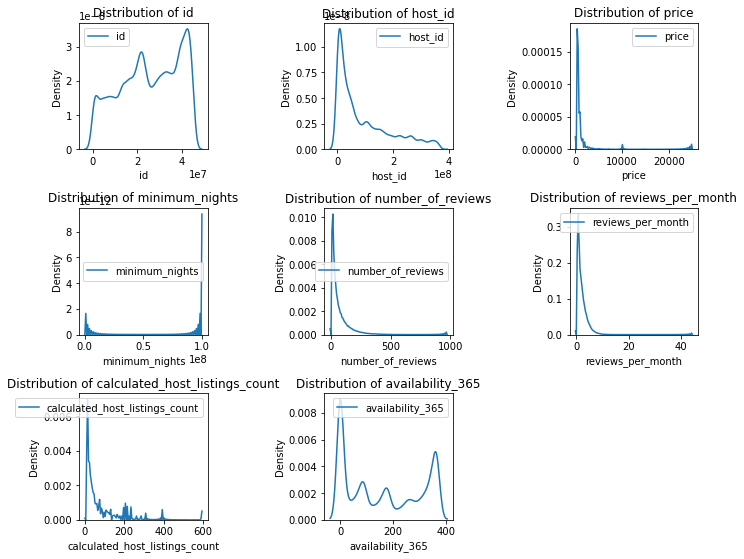

In [4]:
#Outliers
distr_numeric = usaData2.select_dtypes(include=('int', 'float')).columns
plt.figure(figsize = (10,10))

for i, each in enumerate(distr_numeric):
    plt.subplot(4,3,i+1)
    sb.kdeplot(usaData2[each])
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()

According to these plotted distributions, price, reviews per month, minimum nights, and reviews contain outliers which skew the data. The outliers are removed following the price range. 

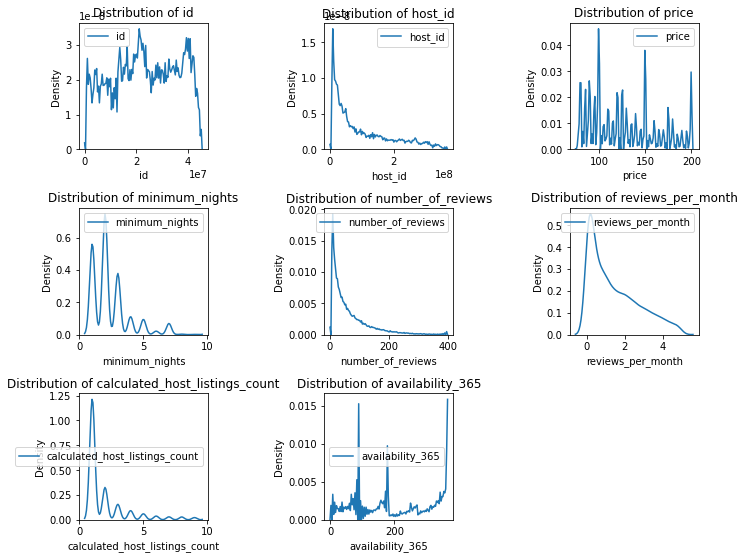

In [5]:
ubound = .75
lbound = .25
cleaned = usaData2[usaData2['price'].between(usaData2['price'].quantile(lbound), usaDataFrame['price'].quantile(ubound), inclusive = True)]
cleaned = cleaned[cleaned['number_of_reviews']>0]
cleaned = cleaned[cleaned['reviews_per_month']<5]
cleaned = cleaned[cleaned['minimum_nights']<10]
cleaned = cleaned[cleaned['calculated_host_listings_count']<10]
cleaned = cleaned[cleaned['number_of_reviews']<400]
#Any other ideas of what limits to put?
numeric_Cleaned = cleaned.select_dtypes(include = ('float', 'int')).columns
plt.figure(figsize=(10,10))
for i, each in enumerate(numeric_Cleaned):
    plt.subplot(4,3,i+1)
    sb.kdeplot(cleaned[each], bw = .2)
    plt.title('Distribution of %s' %each)
    plt.xlabel('%s' %each); plt.ylabel('Density')
    plt.tight_layout()
    
#Words to describe things we can learn from the below graphs.
cleanedUsaData = cleaned.copy(deep=True)


In the distribution above there are a few key observations that we can take away. Firstly, most of the listings are priced as whole numbers, listings requires 1-2 minimally, hosts usually have one listing, and most of the listings are from New York.

STEP 3: Exploring Numerical Features

reviews_per_month                -0.066397
number_of_reviews                -0.056982
id                               -0.007779
host_id                           0.007055
calculated_host_listings_count    0.026635
availability_365                  0.045928
minimum_nights                    0.093901
price                             1.000000
Name: price, dtype: float64

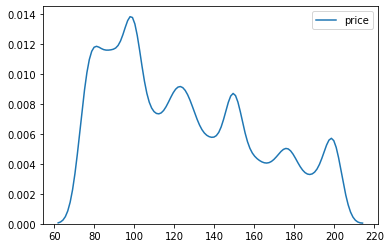

In [6]:
#Explore Numeric Features
#Feature 1 Price:
cleanedUsaData['price'].describe()
cleanedUsaData
sb.kdeplot(cleanedUsaData['price'])
#__________(Add Description of what this means)
#You can see the peak in the blah blah 
#You can see the correlation of numerical features and pricing. 
#&Jerry write more stuff for this!&

correlated = cleanedUsaData.corr()['price'].sort_values()
correlated
#&Graph to display correlation here (PLS do this)&

(array([16902., 22272., 11317.,  3346.,     0.,  2846.,   646.,  2059.,
           85.,    40.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

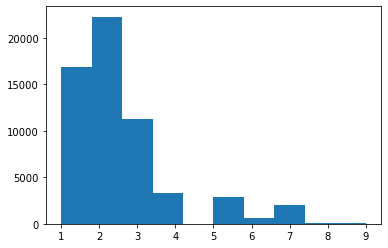

In [7]:
#Feature 2: Minimum Nights
plt.hist(cleanedUsaData['minimum_nights'])
#plot comparing reviews per month and minimum nights

(array([37749.,  9821.,  5295.,  2888.,  1687.,   992.,   558.,   294.,
          148.,    81.]),
 array([  1. ,  40.8,  80.6, 120.4, 160.2, 200. , 239.8, 279.6, 319.4,
        359.2, 399. ]),
 <a list of 10 Patch objects>)

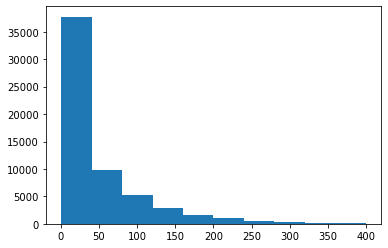

In [8]:
# Feature 3: Number of Reviews
plt.hist(cleanedUsaData['number_of_reviews'])
# plot that shows number of reviews for each AirBNB listing
#& add better description later&

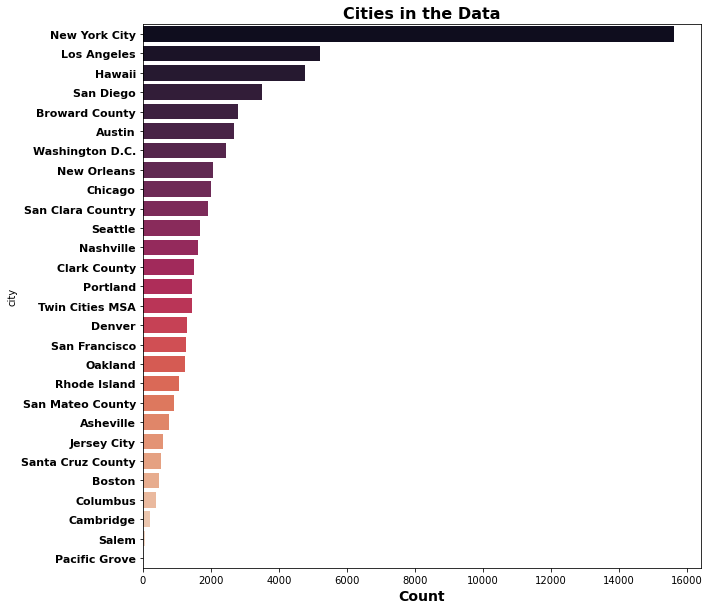

In [9]:
#Cities on the data
#&Edit this -- Note for Arushi
plt.figure(figsize=(10, 10))
n = sb.countplot(y=cleanedUsaData['city'], order = cleanedUsaData['city'].value_counts().index,palette='rocket')
n.set_yticklabels(n.get_yticklabels(), fontsize=11, fontweight='bold')
n.set_title('Cities in the Data', fontsize=16, fontweight= 'bold')
n.set_xlabel('Count', fontsize=14, fontweight='bold')
plt.show()

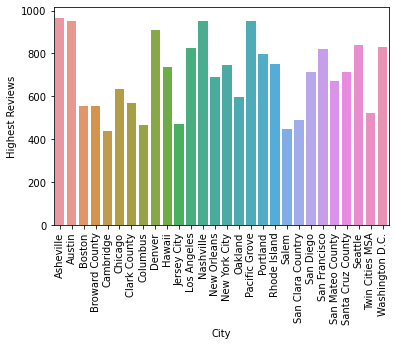

In [10]:
# highest number of reviews per city
grouped = usaDataFrame.groupby(["city"])["number_of_reviews"].max()
reviews = []
temp = []
for city in grouped :
    reviews.append(city)

# Dont delete this commented code for now    
#for index,row in usaDataFrame.iterrows():
#    if (row["number_of_reviews"]==grouped[row["city"]]):
#        temp.append(row["price"])

#city_data = {"City" : np.array(grouped.keys()), "Highest Reviews" : np.array(reviews), "Price for that Home" : np.array(temp)}
#melt = pd.DataFrame(city_data)
#melt2 = pd.melt(melt,id_vars = "City")

#sb.catplot(x = 'City', y='value', hue = 'variable',data=melt2, kind='bar') # highest reviews and the price for city

sb.barplot(grouped.keys(),reviews) #graph only showing highest reviews per city

plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Highest Reviews")
plt.xlabel("City")
plt.show()


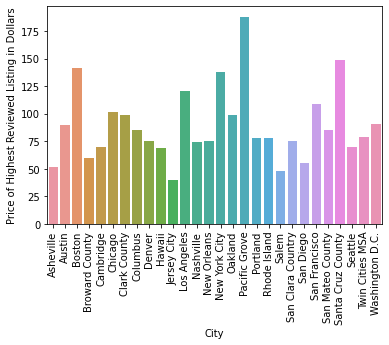

In [11]:
# price of most popular listings in each city
temp = []
for index,row in usaDataFrame.iterrows():
    if (row["number_of_reviews"]==grouped[row["city"]]):
        temp.append(row["price"])
sb.barplot(grouped.keys(),temp) 
plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Price of Highest Reviewed Listing in Dollars")
plt.xlabel("City")
plt.show()


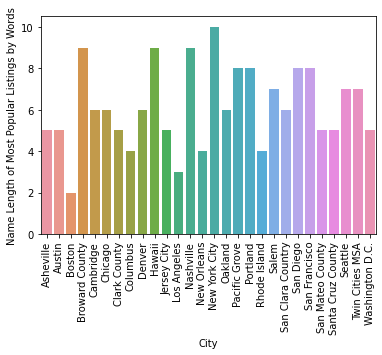

In [12]:
#length of name of most popular listings
name_len = []
usaDataFrame["name"] = usaDataFrame["name"].astype(str)
for index,row in usaDataFrame.iterrows():
    if (row["number_of_reviews"]==grouped[row["city"]]):
        name_len.append(len(row["name"].split(" ")))
sb.barplot(grouped.keys(),name_len)
plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel("Name Length of Most Popular Listings by Words")
plt.xlabel("City")
plt.show()


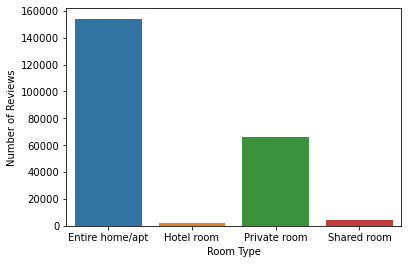

In [13]:
#correlation between number of reviews and room type
rooms = usaDataFrame.groupby(["room_type"])["number_of_reviews"].count()
reviews= []
for room in rooms:
    reviews.append(room)
sb.barplot(rooms.keys(),reviews)
plt.xlabel("Room Type")
plt.ylabel("Number of Reviews")
plt.show()

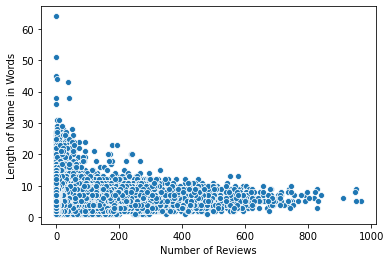

In [14]:
# Overall length of name in characters vs number of reviews

name_len = []
usaDataFrame["name"] = usaDataFrame["name"].astype(str)
for name in usaDataFrame["name"]:
    name_len.append(len(name.split(" ")))
sb.scatterplot(usaDataFrame["number_of_reviews"],name_len)
plt.xlabel("Number of Reviews")
plt.ylabel("Length of Name in Words")
plt.show()

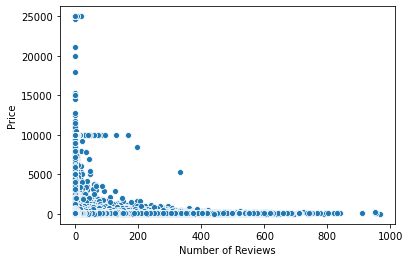

In [15]:
# overall correlation between number of reviews and price
sb.scatterplot(usaDataFrame["number_of_reviews"],usaDataFrame["price"])
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

In [16]:
#Step 5: Explore Catergorial Data
encoder = LabelEncoder()

encoder.fit(cleanedUsaData['room_type'])
encoder_room = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(encoder_room)
cleanedUsaData['room_type'] = encoder.transform(cleanedUsaData['room_type'])

encoder.fit(cleanedUsaData['city'])
encoder_city = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(encoder_city)
usaData2['city'] = encoder.transform(usaData2['city'])

{'Entire home/apt': 0, 'Hotel room': 1, 'Private room': 2, 'Shared room': 3}
{'Asheville': 0, 'Austin': 1, 'Boston': 2, 'Broward County': 3, 'Cambridge': 4, 'Chicago': 5, 'Clark County': 6, 'Columbus': 7, 'Denver': 8, 'Hawaii': 9, 'Jersey City': 10, 'Los Angeles': 11, 'Nashville': 12, 'New Orleans': 13, 'New York City': 14, 'Oakland': 15, 'Pacific Grove': 16, 'Portland': 17, 'Rhode Island': 18, 'Salem': 19, 'San Clara Country': 20, 'San Diego': 21, 'San Francisco': 22, 'San Mateo County': 23, 'Santa Cruz County': 24, 'Seattle': 25, 'Twin Cities MSA': 26, 'Washington D.C.': 27}


Text(0.5, 0, 'room_type')

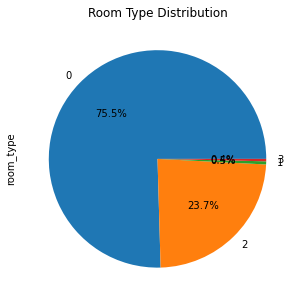

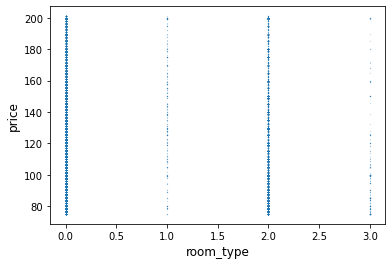

In [17]:
#Room Types: Most rooms are homes, apartments or private rooms
#&Relabel the graph&
plt.figure(figsize = (5,5))
cleanedUsaData.room_type.value_counts().plot.pie(autopct="%.1f%%", title = "Room Type Distribution")
fig, n = plt.subplots()
n.scatter(x = cleanedUsaData['room_type'], y = cleanedUsaData['price'], s = 0.01)
plt.ylabel('price', fontsize=12)
plt.xlabel('room_type', fontsize =12)

Text(0.5, 1.0, 'Word length in Name')

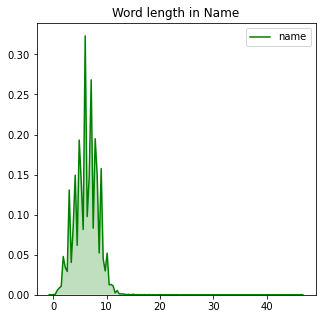

In [18]:
#Explire the Length of Descriptions and Words in listings
lengths = cleanedUsaData['name'].apply(lambda n: len(str(n).split()))
lengths.describe()

plt.figure(figsize=(5, 5))
sb.kdeplot(lengths, shade=True, color='green').set_title('Word length in Name')


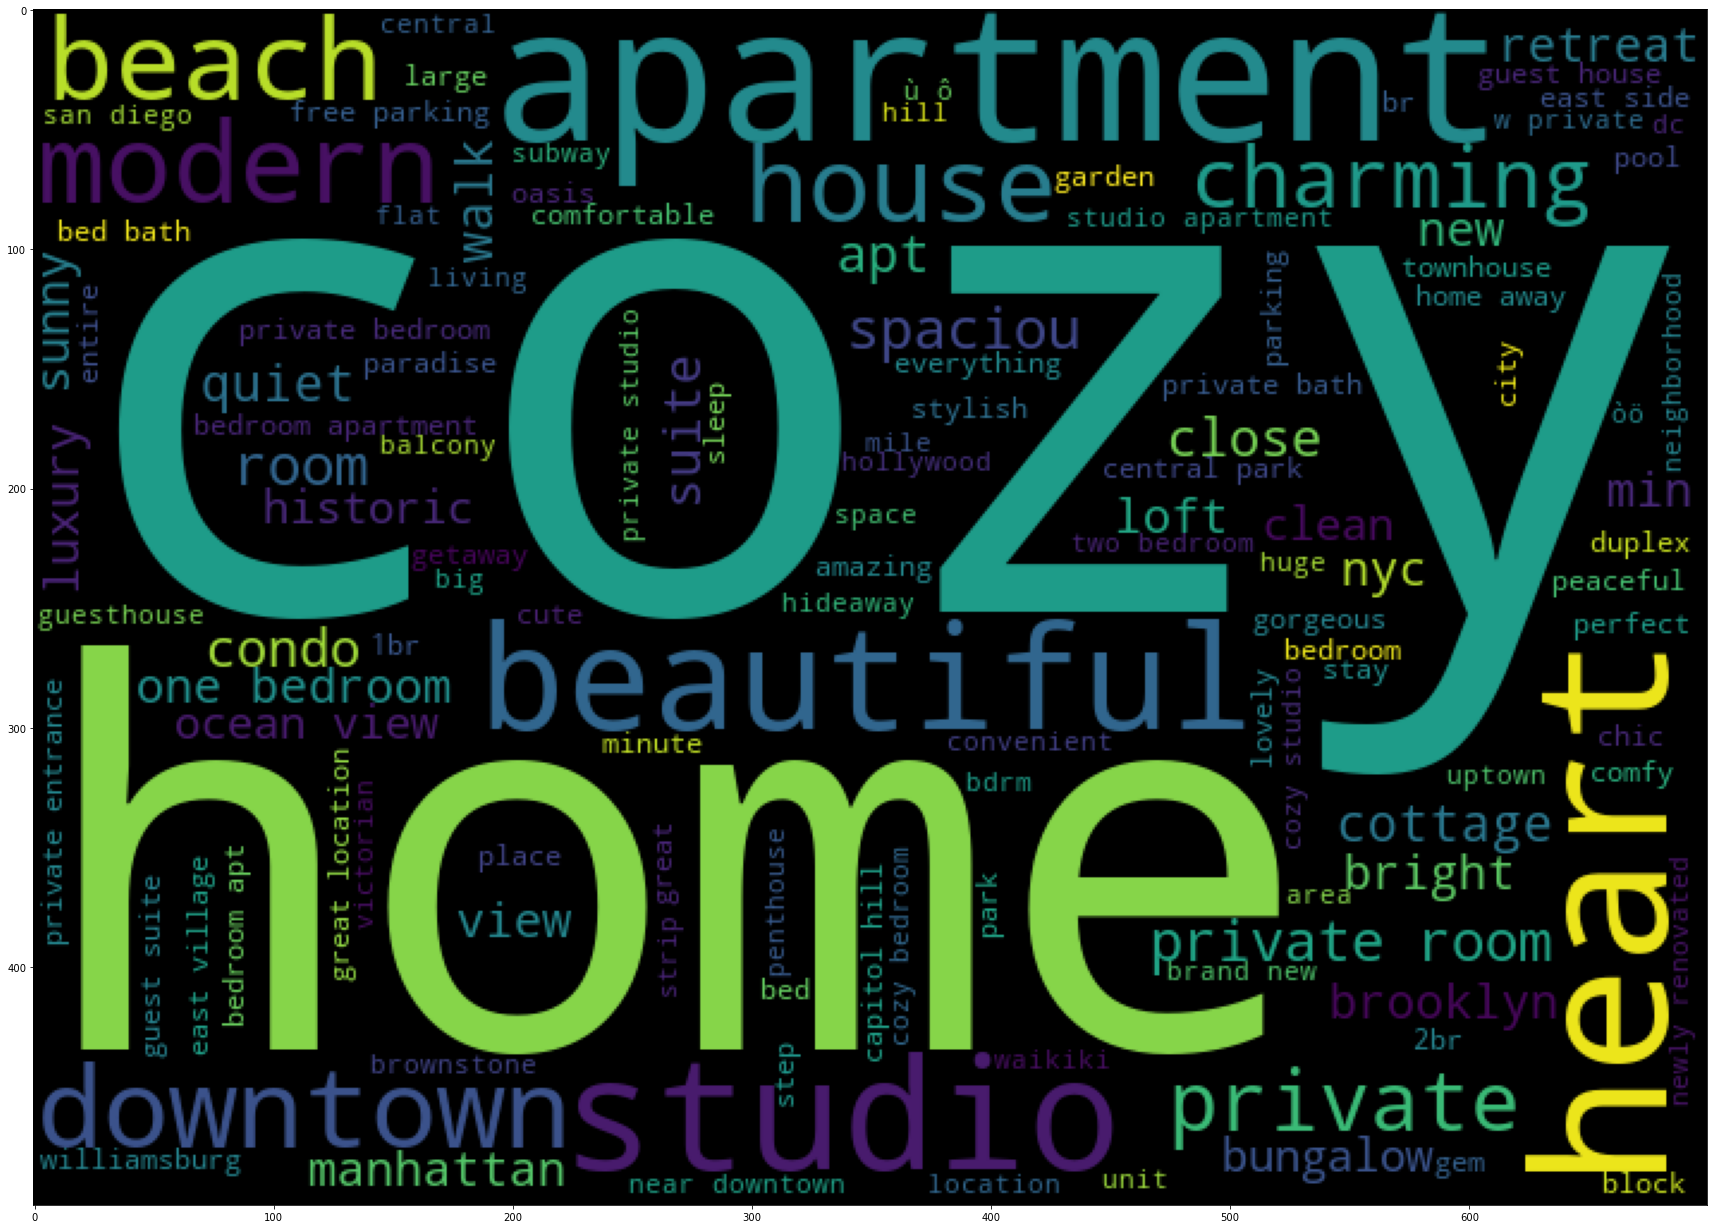

In [19]:
#Exploring the most used word in the Listing
#MAKE A WORD CLOUD
y = cleanedUsaData['name'].astype(str)
listToString= ' '.join([str(elem) for elem in y if elem not in STOPWORDS]).lower()
plt.figure(figsize = (30, 30))
wordcloud = WordCloud(width=700, height = 500, min_font_size=10).generate(listToString)
plt.imshow(wordcloud)

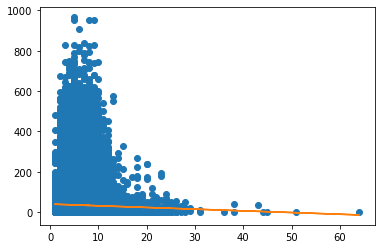

In [20]:
# creates a name length column based on number of words in name
usaDataFrame["name_length"] = usaDataFrame["name"].apply(lambda x: len(x.split(" ")))
from sklearn.linear_model import LinearRegression
X_train = np.array(usaDataFrame["name_length"]).reshape(-1,1)
#X_test = np.array(usaDataFrame["number_of_reviews"]).reshape(-1,1)
Y_train = np.array(usaDataFrame["number_of_reviews"])
#Y_test = np.array(usaDataFrame["name_length"])

lin_reg = LinearRegression().fit(X_train,Y_train)

y_predict = lin_reg.predict(X_train)
#print(lin_reg.score(X_train,Y_train))
#print(lin_reg.coef_)
#print(y_predict)

#plt.plot(X_train,y_predict,color='r')
#plt.scatter(X_train,Y_train)

# Manual way of fitting a linear regression to verify
X_train = np.array(usaDataFrame["name_length"])
plt.plot(X_train, Y_train, 'o')
m, b = np.polyfit(X_train, Y_train, 1)
plt.plot(X_train, m*X_train + b)
